In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import time
import math
import random
import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import datasets, layers, models
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from sklearn.cluster import KMeans, AgglomerativeClustering
from tensorflow.keras.datasets import cifar10
from keras.datasets import fashion_mnist 
from sklearn.metrics import silhouette_samples, silhouette_score

mod = sys.modules[__name__]

In [2]:
def distribution_check(dataset):
        #분포가 다름;
    one,two,three,four,five,six,seven,eight,nine,ten=0,0,0,0,0,0,0,0,0,0

    for i in range(len(dataset)):
        if(dataset[i]==1):    one+=1
        elif(dataset[i]==2):  two+=1
        elif(dataset[i]==3):  three+=1
        elif(dataset[i]==4):  four+=1
        elif(dataset[i]==5):  five+=1
        elif(dataset[i]==6):  six+=1
        elif(dataset[i]==7):  seven+=1
        elif(dataset[i]==8):  eight+=1
        elif(dataset[i]==9):  nine+=1
        elif(dataset[i]==0):  ten+=1

    #print(one,two,three,four,five,six,seven,eight,nine,ten)
    #print("Sum : ", one+two+three+four+five+six+seven+eight+nine+ten)
    sums = one+two+three+four+five+six+seven+eight+nine+ten
    for_graph=[one,two,three,four,five,six,seven,eight,nine,ten]
    
    return for_graph, sums

def local_model_generate(model): #초기 모델 생성
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

def step_function(data):
    if data > 0:
        return 1
    else:
        return 0

def sigmoid(data):
    return 1/(1+np.exp(-data))

def relu(data):
    return np.maximum(0,data)

def random_check(local, train_data, test_data):
    check_distribution_train_data, check_distribution_test_data, y_train_tmp, y_test_tmp = [], [], [], []
    sum1, sum2, data_index = 0,0, np.arange(0,10)

    for j in range(len(train_data)):
        y_train_tmp.append(np.argmax(train_data[j])) #원핫인코딩에서 다시 0~9 레이블로 변환

    for j in range(len(test_data)):
        y_test_tmp.append(np.argmax(test_data[j]))

    check_distribution_train_data, sum_train = distribution_check(y_train_tmp) #한번 밖에 실행 못함
    check_distribution_test_data, sum_test = distribution_check(y_test_tmp)
    sum1, sum2 = (sum1 + sum_train), (sum2 + sum_test)
    
    return check_distribution_train_data, check_distribution_test_data


In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape, x_test.shape)
num_train, num_test = len(x_train),  len(x_test) 

(60000, 28, 28) (10000, 28, 28)


In [4]:
local = 21 # 10개 : 1~10 => 11은 포함 안됨
batch_size, epochs = 32, 10
global_epoch = 0
num_layers = 8

In [5]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print("Step 1 x_train shape:", x_train.shape)

x_train = x_train.reshape((num_train, 28, 28, 1))
x_test = x_test.reshape((num_test, 28, 28, 1))

print("Step 2 x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
# convert class vectors to binary class matrices => one hot encoding 지금은 [3,6,2,5,4,8..] 섞여있음 

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Step 1 x_train shape: (60000, 28, 28)
Step 2 x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [11]:
global_epoch = 0

print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")

for i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화
    globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [],[]  
    globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [],[]  


for n in range(1,local): #x_train_range, 잘 작동함 => 확인 완료

    x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
    x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

    tmp, tmp2 = [], []

    num_pick = random.randint(1000, 5000 ) #변동 사항 #int(len(list(x_train_range))/local)
    num_pick2 = int(len(x_test_range)/local) #test 데이터는 원래대로 항상 일정한 비율로 주면 될듯 => 어느정도 분량 이상 있어야 함
    
    tmp = random.sample(list(x_train_range), num_pick)  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
    tmp2 = random.sample(list(x_test_range), num_pick2)

    for i in range(len(tmp)):
        globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
        globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
        #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소갯수들 추출했으니 안에서 삭제  => 오래걸림

    for j in range(len(tmp2)):
        globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
        globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
        #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 1000개 추출했으니 안에서 삭제  => 오래걸림
    
    print("CHECK :", n," 번째 로컬 클라이언트 Number of Training sets : ", len(globals()['L{}_x_train'.format(n)]), "   Number of Training sets : ", len(globals()['L{}_x_test'.format(n)]))

print("check=>: should be 0 == ", len(x_train_range))  #원소 하나도 없어야 함. 확인.
print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!")

0  번째 global_epoch 데이터 랜덤하게 준비!!
CHECK : 1  번째 로컬 클라이언트 Number of Training sets :  4490    Number of Training sets :  476
CHECK : 2  번째 로컬 클라이언트 Number of Training sets :  1114    Number of Training sets :  476
CHECK : 3  번째 로컬 클라이언트 Number of Training sets :  1649    Number of Training sets :  476
CHECK : 4  번째 로컬 클라이언트 Number of Training sets :  4292    Number of Training sets :  476
CHECK : 5  번째 로컬 클라이언트 Number of Training sets :  4777    Number of Training sets :  476
CHECK : 6  번째 로컬 클라이언트 Number of Training sets :  2566    Number of Training sets :  476
CHECK : 7  번째 로컬 클라이언트 Number of Training sets :  1362    Number of Training sets :  476
CHECK : 8  번째 로컬 클라이언트 Number of Training sets :  2839    Number of Training sets :  476
CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  1090    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  4813    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  1003    Number of Trainin

In [13]:
#준비된 데이터 (IID / NON-IID) np.array로

local = 21

global_epoch = 0
FedAvg_ACC, FedAvg_LOSS, fedavg_acc, fedavg_loss, acc, loss = [], [], [], [], 0, 0
num_layers_list = [0,2,4,6,7]
label_list = []

VAR_final_list_w, VAR_final_list_b = [], []


for i in range(1,local):
    globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
    globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
    globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
    globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


print("\n\n",global_epoch, "번째 global epoch에서 로컬 클라이언트 학습시작!\n\n학습 중 ...\n")
now = time.time()

for i in range(1,local):
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = models.Sequential()  ##!!!!!!! 이게 글로벌 epoch에서는 2번째 부터 들어가면 안됨
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = local_model_generate(globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)])      # initialize 필요 => 모델 프레임 구축

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)

    loss, acc = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].evaluate(globals()['L{}_x_test'.format(i,global_epoch)], globals()['L{}_y_test'.format(i)], verbose=2)
    
    fedavg_acc.append(acc)  #acc 넣기
    fedavg_loss.append(loss)  #loss 넣기


print(global_epoch, "번째 global epoch 로컬 클라이언트 학습완료!,  Total Training time : ", time.time()-now,"\n\n")

# 로컬 모델들 학습 완료하였고 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------

for i in range(1, local):
    for layer_index in num_layers_list:
        w = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].layers[layer_index].get_weights() #get_weights = w[0],b[1]로 구성

        globals()['L{}_layer{}_w_tmp'.format(i,layer_index)] = w      # 클러스터링 용도
        globals()['L{}_layer{}_w'.format(i,layer_index)] = w          # weight aggregation 용도
            
# 클러스터에 넣을 변수 선언

for layer_index in num_layers_list:

    globals()['layer{}_W_tmp'.format(layer_index)] = []
    globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = 0  #FedAvg 용도
    
    globals()['var_list_layer{}_w'.format(layer_index)] = []
    globals()['var_list_layer{}_b'.format(layer_index)] = []
  
    w_scaler = 0
    #------------------------------------------------FedAvg--------------------------------------------------------
    for i in range(1, local):
        globals()['var_list_layer{}_w'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][0]))
        globals()['var_list_layer{}_b'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][1]))
      
        w_scaler = len(globals()['L{}_x_train'.format(i)]) / 60000
        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + (np.array(globals()['L{}_layer{}_w'.format(i,layer_index)]) * w_scaler)
    
    globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = np.array(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)]) / (local-1)   #np.array로 변함
    
    VAR_final_list_w.append(globals()['var_list_layer{}_w'.format(layer_index)])
    VAR_final_list_b.append(globals()['var_list_layer{}_b'.format(layer_index)])
    
#---------------------------------------------------------메모리 삭제-------------------------------------------------------------------


FedAvg_ACC.append(fedavg_acc)
FedAvg_LOSS.append(fedavg_loss)

## G{}_num_clusters_in_layer{}_w 에 속하는 거 말고 삭제 = 메모리 낭비

# Weight, bias 합친 것
 # FedAvg                   :  G{}_w_layer
 # 일반 클러스터링          :  G{}_c{}_w_layer{}               클러스터 갯수 파악 : G{}_num_clusters_in_layer{}_w
 # Actiavtion + 클러스터링  :  G{}_c{}_w_layer{}_Act           클러스터 갯수 파악 : G{}_num_clusters_in_layer{}_w_c_a



 0 번째 global epoch에서 로컬 클라이언트 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.5177 - accuracy: 0.8130
15/15 - 0s - loss: 0.7900 - accuracy: 0.7227
15/15 - 0s - loss: 0.5462 - accuracy: 0.7752
15/15 - 0s - loss: 0.4007 - accuracy: 0.8466
15/15 - 0s - loss: 0.4858 - accuracy: 0.8424
15/15 - 0s - loss: 0.4933 - accuracy: 0.8466
15/15 - 0s - loss: 0.6394 - accuracy: 0.7668
15/15 - 0s - loss: 0.4325 - accuracy: 0.8340
15/15 - 0s - loss: 0.6203 - accuracy: 0.7668
15/15 - 0s - loss: 0.5035 - accuracy: 0.8277
15/15 - 0s - loss: 0.7498 - accuracy: 0.7017
15/15 - 0s - loss: 0.4039 - accuracy: 0.8508
15/15 - 0s - loss: 0.4102 - accuracy: 0.8571
15/15 - 0s - loss: 0.5388 - accuracy: 0.8067
15/15 - 0s - loss: 0.5795 - accuracy: 0.7668
15/15 - 0s - loss: 0.7101 - accuracy: 0.7332
15/15 - 0s - loss: 0.5186 - accuracy: 0.8340
15/15 - 0s - loss: 0.5252 - accuracy: 0.8004
15/15 - 0s - loss: 0.4933 - accuracy: 0.8487
15/15 - 0s - loss: 0.4755 - accuracy: 0.8361
0 번째 global epoch 로컬 클라이언트 학습완료!,  Total Training t

<ipython-input-13-04786439ab09>:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + (np.array(globals()['L{}_layer{}_w'.format(i,layer_index)]) * w_scaler)


In [14]:
local = 21

G_epoch = 51

for global_epoch in range(1, G_epoch):

    for layer_index in num_layers_list:
        for i in range(1, local):  #FedAvg
            globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch)] = globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch-1)]   #구조만 필요

            globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch)].layers[layer_index].set_weights(globals()['G{}_w_layer{}'.format(global_epoch-1, layer_index)])  #set_weights
        

    #----------------------------------------------------------------데이터 새로 준비----------------------------------------------------------------------------------
    print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")


    for i in range(1,local):
        globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [], []
        globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [], []  
        
    for n in range(1,local): #x_train_range, 잘 작동함 => 확인 완료

        x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
        x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

        tmp, tmp2 = [], []

        num_pick = random.randint(1000, int(len(list(x_train_range))/local) ) #변동 사항
        num_pick2 = int(len(x_test_range)/local) #test 데이터는 원래대로 항상 일정한 비율로 주면 될듯 => 어느정도 분량 이상 있어야 함

        tmp = random.sample(list(x_train_range), num_pick)  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
        tmp2 = random.sample(list(x_test_range), num_pick2)

        for i in range(len(tmp)):
            globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
            globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
            #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소갯수들 추출했으니 안에서 삭제  => 오래걸림

        for j in range(len(tmp2)):
            globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
            globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
            #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 1000개 추출했으니 안에서 삭제  => 오래걸림


    for i in range(1,local):
        globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
        globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
        globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
        globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])

    print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!\n\n")
    print(global_epoch, " 번째 global epoch에서 로컬 클라이언트 들 학습시작!\n\n학습 중 ...\n")
    
    
    
    #-------------------------------------------------------------------여기가 핵심, 알고리즘 3개 따로 학습시켜야 함--------------------------------------------------------------------

    #======================================================================== FedAvg ========================================================================

    fedavg_acc, fedavg_loss, now = [],[], time.time()

    for i in range(1,local):
        # 아까 옮겨줘서 모델 그대로 compile, train 시키면 됨      
        globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

        globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)

        loss, acc = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].evaluate(globals()['L{}_x_test'.format(i)], globals()['L{}_y_test'.format(i)], verbose=2)
        
        fedavg_acc.append(acc)  #acc 넣기
        fedavg_loss.append(loss)  #loss 넣기

    print("------------   ", global_epoch, " 번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time : ", time.time()-now,"---------------------------\n\n")


# 로컬 모델들 학습 완료, 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------


    for i in range(1, local):        
        for layer_index in num_layers_list:
            globals()['L{}_layer{}_w_tmp'.format(i,layer_index)] = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].layers[layer_index].get_weights() #get_weights = w[0],b[1]로 구성, FedAvg
            
    #------------------------------------------------FedAvg--------------------------------------------------------바로 Fedavg 시키기
    
    for layer_index in num_layers_list:
        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = 0

        globals()['var_list_layer{}_w'.format(layer_index)] = []
        globals()['var_list_layer{}_b'.format(layer_index)] = []
        w_scaler = len(globals()['L{}_x_train'.format(i)]) / 60000
        
        for i in range(1, local):
            globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + (np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)])*w_scaler)

        for i in range(1, local):
            globals()['var_list_layer{}_w'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][0]))            
            globals()['var_list_layer{}_b'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][1]))
            
          
        VAR_final_list_w.append(globals()['var_list_layer{}_w'.format(layer_index)])
        VAR_final_list_b.append(globals()['var_list_layer{}_b'.format(layer_index)])
    

    FedAvg_ACC.append(fedavg_acc)
    FedAvg_LOSS.append(fedavg_loss)

    print("\n\n====================================================== One Global Epoch =====================================================================\n\n")


1  번째 global_epoch 데이터 랜덤하게 준비!!
1  번째 global_epoch 데이터 랜덤 준비완료!!


1  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 2.3029 - accuracy: 0.0945
15/15 - 0s - loss: 2.3045 - accuracy: 0.0861
15/15 - 0s - loss: 0.9849 - accuracy: 0.6092
15/15 - 0s - loss: 0.9925 - accuracy: 0.5819
15/15 - 0s - loss: 2.2991 - accuracy: 0.1071
15/15 - 0s - loss: 2.3025 - accuracy: 0.1050
15/15 - 0s - loss: 2.3040 - accuracy: 0.1134
15/15 - 0s - loss: 1.0571 - accuracy: 0.5567
15/15 - 0s - loss: 1.0237 - accuracy: 0.6408
15/15 - 0s - loss: 2.3095 - accuracy: 0.0840
15/15 - 0s - loss: 2.3022 - accuracy: 0.1008
15/15 - 0s - loss: 2.3027 - accuracy: 0.1050
15/15 - 0s - loss: 2.3062 - accuracy: 0.1134
15/15 - 0s - loss: 2.3028 - accuracy: 0.0882
15/15 - 0s - loss: 2.3038 - accuracy: 0.1071
15/15 - 0s - loss: 2.3051 - accuracy: 0.0903
15/15 - 0s - loss: 0.9058 - accuracy: 0.6408
15/15 - 0s - loss: 2.3054 - accuracy: 0.1092
15/15 - 0s - loss: 2.3006 - accuracy: 0.1050
15/15 - 0s - loss: 2.3069 - 

<ipython-input-14-b9071cc87a2b>:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + (np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)])*w_scaler)


2  번째 global_epoch 데이터 랜덤 준비완료!!


2  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.8974 - accuracy: 0.6681
15/15 - 0s - loss: 0.8355 - accuracy: 0.6870
15/15 - 0s - loss: 0.8977 - accuracy: 0.7185
15/15 - 0s - loss: 0.7006 - accuracy: 0.7332
15/15 - 0s - loss: 0.8855 - accuracy: 0.6828
15/15 - 0s - loss: 0.8425 - accuracy: 0.6975
15/15 - 0s - loss: 0.8571 - accuracy: 0.6891
15/15 - 0s - loss: 0.7727 - accuracy: 0.6849
15/15 - 0s - loss: 0.8902 - accuracy: 0.6513
15/15 - 0s - loss: 1.0583 - accuracy: 0.6092
15/15 - 0s - loss: 0.8943 - accuracy: 0.6576
15/15 - 0s - loss: 0.7298 - accuracy: 0.7080
15/15 - 0s - loss: 0.9969 - accuracy: 0.6050
15/15 - 0s - loss: 0.8254 - accuracy: 0.6996
15/15 - 0s - loss: 0.9015 - accuracy: 0.6471
15/15 - 0s - loss: 0.8940 - accuracy: 0.6681
15/15 - 0s - loss: 0.9037 - accuracy: 0.6366
15/15 - 0s - loss: 0.7500 - accuracy: 0.7395
15/15 - 0s - loss: 0.9067 - accuracy: 0.6471
15/15 - 0s - loss: 0.7624 - accuracy: 0.7122
------------    

15/15 - 0s - loss: 0.6493 - accuracy: 0.7794
15/15 - 0s - loss: 0.6832 - accuracy: 0.7857
15/15 - 0s - loss: 0.6945 - accuracy: 0.7752
15/15 - 0s - loss: 0.7529 - accuracy: 0.7479
15/15 - 0s - loss: 0.5521 - accuracy: 0.7983
15/15 - 0s - loss: 0.7019 - accuracy: 0.7563
15/15 - 0s - loss: 0.5614 - accuracy: 0.7773
15/15 - 0s - loss: 0.6704 - accuracy: 0.7668
15/15 - 0s - loss: 0.5767 - accuracy: 0.7836
15/15 - 0s - loss: 0.5823 - accuracy: 0.7941
15/15 - 0s - loss: 0.6166 - accuracy: 0.7710
15/15 - 0s - loss: 0.6437 - accuracy: 0.7752
------------    8  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  127.84316945075989 ---------------------------




====================================================== One Global Epoch =====================================================================


9  번째 global_epoch 데이터 랜덤하게 준비!!
9  번째 global_epoch 데이터 랜덤 준비완료!!


9  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.6388 - accuracy: 0.7626
15/15 - 0s - los

15/15 - 0s - loss: 0.5184 - accuracy: 0.8256
15/15 - 0s - loss: 0.5824 - accuracy: 0.8088
15/15 - 0s - loss: 0.5117 - accuracy: 0.8004
------------    14  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  141.31466507911682 ---------------------------




====================================================== One Global Epoch =====================================================================


15  번째 global_epoch 데이터 랜덤하게 준비!!
15  번째 global_epoch 데이터 랜덤 준비완료!!


15  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.5251 - accuracy: 0.8130
15/15 - 0s - loss: 0.6046 - accuracy: 0.7920
15/15 - 0s - loss: 0.5711 - accuracy: 0.7941
15/15 - 0s - loss: 0.5414 - accuracy: 0.8046
15/15 - 0s - loss: 0.6002 - accuracy: 0.7710
15/15 - 0s - loss: 0.4892 - accuracy: 0.8256
15/15 - 0s - loss: 0.5426 - accuracy: 0.8151
15/15 - 0s - loss: 0.5521 - accuracy: 0.8067
15/15 - 0s - loss: 0.5337 - accuracy: 0.8109
15/15 - 0s - loss: 0.6244 - accuracy: 0.7941
15/15 - 0s -

21  번째 global_epoch 데이터 랜덤 준비완료!!


21  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.5399 - accuracy: 0.8298
15/15 - 0s - loss: 0.4740 - accuracy: 0.8319
15/15 - 0s - loss: 0.6432 - accuracy: 0.7710
15/15 - 0s - loss: 0.4953 - accuracy: 0.8277
15/15 - 0s - loss: 0.4781 - accuracy: 0.8340
15/15 - 0s - loss: 0.4905 - accuracy: 0.8235
15/15 - 0s - loss: 0.4564 - accuracy: 0.8256
15/15 - 0s - loss: 0.5041 - accuracy: 0.8172
15/15 - 0s - loss: 0.5589 - accuracy: 0.8046
15/15 - 0s - loss: 0.6235 - accuracy: 0.7563
15/15 - 0s - loss: 0.4502 - accuracy: 0.8319
15/15 - 0s - loss: 0.4744 - accuracy: 0.8382
15/15 - 0s - loss: 0.5508 - accuracy: 0.8235
15/15 - 0s - loss: 0.5172 - accuracy: 0.8109
15/15 - 0s - loss: 0.4583 - accuracy: 0.8340
15/15 - 0s - loss: 0.5725 - accuracy: 0.8130
15/15 - 0s - loss: 0.5602 - accuracy: 0.7962
15/15 - 0s - loss: 0.5016 - accuracy: 0.8382
15/15 - 0s - loss: 0.5071 - accuracy: 0.8193
15/15 - 0s - loss: 0.4251 - accuracy: 0.8529
------------  

15/15 - 0s - loss: 0.5453 - accuracy: 0.8172
15/15 - 0s - loss: 0.5310 - accuracy: 0.8277
15/15 - 0s - loss: 0.5147 - accuracy: 0.8424
15/15 - 0s - loss: 0.4698 - accuracy: 0.8256
15/15 - 0s - loss: 0.5089 - accuracy: 0.8088
15/15 - 0s - loss: 0.6098 - accuracy: 0.8004
15/15 - 0s - loss: 0.5797 - accuracy: 0.8004
15/15 - 0s - loss: 0.4807 - accuracy: 0.8382
15/15 - 0s - loss: 0.5674 - accuracy: 0.7899
15/15 - 0s - loss: 0.5476 - accuracy: 0.8151
15/15 - 0s - loss: 0.5450 - accuracy: 0.7983
15/15 - 0s - loss: 0.5365 - accuracy: 0.8172
15/15 - 0s - loss: 0.5404 - accuracy: 0.8319
------------    27  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  287.9068684577942 ---------------------------




====================================================== One Global Epoch =====================================================================


28  번째 global_epoch 데이터 랜덤하게 준비!!
28  번째 global_epoch 데이터 랜덤 준비완료!!


28  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - 

15/15 - 0s - loss: 0.4595 - accuracy: 0.8277
15/15 - 0s - loss: 0.6278 - accuracy: 0.7857
15/15 - 0s - loss: 0.4021 - accuracy: 0.8634
15/15 - 0s - loss: 0.5593 - accuracy: 0.7962
------------    33  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  382.45331144332886 ---------------------------




====================================================== One Global Epoch =====================================================================


34  번째 global_epoch 데이터 랜덤하게 준비!!
34  번째 global_epoch 데이터 랜덤 준비완료!!


34  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.6131 - accuracy: 0.7983
15/15 - 0s - loss: 0.5242 - accuracy: 0.8004
15/15 - 0s - loss: 0.5603 - accuracy: 0.7815
15/15 - 0s - loss: 0.5657 - accuracy: 0.7605
15/15 - 0s - loss: 0.5641 - accuracy: 0.8193
15/15 - 0s - loss: 0.5159 - accuracy: 0.8067
15/15 - 0s - loss: 0.5120 - accuracy: 0.8214
15/15 - 0s - loss: 0.7003 - accuracy: 0.7563
15/15 - 0s - loss: 0.5589 - accuracy: 0.7941
15/15 - 0s -

40  번째 global_epoch 데이터 랜덤 준비완료!!


40  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.5761 - accuracy: 0.8214
15/15 - 0s - loss: 0.5577 - accuracy: 0.8277
15/15 - 0s - loss: 0.5834 - accuracy: 0.7962
15/15 - 0s - loss: 0.5245 - accuracy: 0.8235
15/15 - 0s - loss: 0.4828 - accuracy: 0.8319
15/15 - 0s - loss: 0.5111 - accuracy: 0.8151
15/15 - 0s - loss: 0.6848 - accuracy: 0.7836
15/15 - 0s - loss: 0.5406 - accuracy: 0.8235
15/15 - 0s - loss: 0.4973 - accuracy: 0.8361
15/15 - 0s - loss: 0.6352 - accuracy: 0.7710
15/15 - 0s - loss: 0.6258 - accuracy: 0.7878
15/15 - 0s - loss: 0.5173 - accuracy: 0.8193
15/15 - 0s - loss: 0.4355 - accuracy: 0.8235
15/15 - 0s - loss: 0.5083 - accuracy: 0.8172
15/15 - 0s - loss: 0.5995 - accuracy: 0.7710
15/15 - 1s - loss: 0.4690 - accuracy: 0.8256
15/15 - 1s - loss: 0.5814 - accuracy: 0.8004
15/15 - 0s - loss: 0.6569 - accuracy: 0.7815
15/15 - 0s - loss: 0.4984 - accuracy: 0.8298
15/15 - 0s - loss: 0.5154 - accuracy: 0.8088
------------  

15/15 - 1s - loss: 0.5289 - accuracy: 0.8277
15/15 - 1s - loss: 0.4486 - accuracy: 0.8529
15/15 - 1s - loss: 0.5367 - accuracy: 0.8067
15/15 - 1s - loss: 0.4968 - accuracy: 0.8361
15/15 - 1s - loss: 0.4466 - accuracy: 0.8550
15/15 - 1s - loss: 0.5891 - accuracy: 0.8025
15/15 - 1s - loss: 0.6349 - accuracy: 0.8025
15/15 - 1s - loss: 0.5684 - accuracy: 0.8109
15/15 - 1s - loss: 0.5209 - accuracy: 0.7983
15/15 - 1s - loss: 0.4808 - accuracy: 0.8214
15/15 - 1s - loss: 0.5109 - accuracy: 0.8298
15/15 - 1s - loss: 0.5532 - accuracy: 0.8298
15/15 - 1s - loss: 0.5336 - accuracy: 0.7962
------------    46  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  1248.5545465946198 ---------------------------




====================================================== One Global Epoch =====================================================================


47  번째 global_epoch 데이터 랜덤하게 준비!!
47  번째 global_epoch 데이터 랜덤 준비완료!!


47  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 1s -

# Var 그래프 : 누적량이랑 변화량

Variance Accumulate Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------


Var Accumulate Weight
--------------------------------------
[2.6524733e-06, 2.9254534e-05, 0.0023605172, 0.002088891, 0.0005742929, 0.0021904008, 0.0009801927, 0.0026992494, 0.0019525473, 0.005050151, 0.004368399, 0.0016550615, 0.0046484713, 0.0046809106, 0.0047850525, 0.005242733, 0.003922987, 0.0065578353, 0.008613621, 0.010813213, 0.0028687574, 0.0036354512, 0.001248349, 0.0022517364, 0.006318813, 0.0061936844, 0.008291581, 0.00302473, 0.0014697039, 0.005007359, 0.0041706506, 0.0016011114, 0.0024839872, 0.0015460369, 0.003686563, 0.0035736982, 0.004663797, 0.007364996, 0.0030685822, 0.0042761294, 0.007757487, 0.0016417082, 0.0045445473, 0.0013868541, 0.0066633, 0.0068605137, 0.005564898, 0.0031329999, 0.0053802677, 0.009619315]
[9.076159e-07, 8.13593e-06, 0.0015398026, 0.0014068722, 0.00044507574, 0.0021699234, 0.0008691952, 0.002432502, 0.0014687

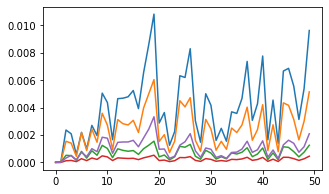

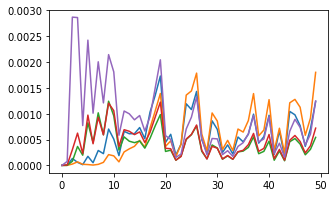

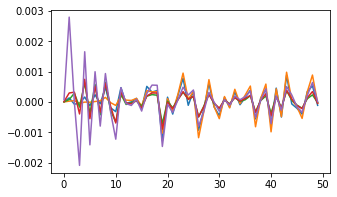

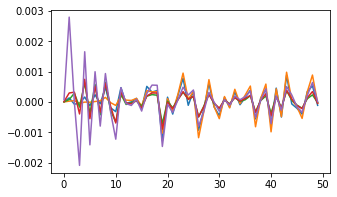

In [15]:
var_changes_L0_w, var_changes_L2_w, var_changes_L4_w, var_changes_L6_w, var_changes_L7_w = [], [], [], [], [] 
var_accumulate_L0_w, var_accumulate_L2_w, var_accumulate_L4_w, var_accumulate_L6_w, var_accumulate_L7_w = [], [], [], [], [] 

var_changes_L0_b, var_changes_L2_b, var_changes_L4_b, var_changes_L6_b, var_changes_L7_b = [], [], [], [], [] 
var_accumulate_L0_b, var_accumulate_L2_b, var_accumulate_L4_b, var_accumulate_L6_b, var_accumulate_L7_b = [], [], [], [], [] 


for global_epoch in range(G_epoch-1):
    for layer_index in num_layers_list:
        globals()['var_accumulate_L{}_w'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][0]))
        globals()['var_changes_L{}_w'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)][0]) - np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][0]))
        
        globals()['var_accumulate_L{}_b'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][1]))
        globals()['var_changes_L{}_b'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)][1]) - np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][1]))
        

print("Variance Accumulate Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Accumulate Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_w'.format(j)])

print("\nVar Accumulate Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_b'.format(j)])

print("\n\nVariance Change Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Changes Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_w'.format(j)])

print("\nVar Changes Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_changes_L{}_b'.format(j)])



print("\nNow Check the graph\n")

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_w'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_b'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_b'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_b'.format(j)])


# 글로벌 에폭 변하는 동안 레이어들간에 거리 그래프

Distance Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------
[0.0068206633, 0.042629346, 0.010888641, 0.02046101, 0.031304862, 0.021462375, 0.027813932, 0.013629724, 0.033958588, 0.01520185, 0.026696792, 0.03835136, 0.008123777, 0.0042161397, 0.005652284, 0.011984375, 0.026986068, 0.0123956315, 0.011380257, 0.059574418, 0.014851683, 0.027420346, 0.018145114, 0.043845657, 0.010276935, 0.015870262, 0.04634525, 0.017920656, 0.047164015, 0.011048411, 0.032012, 0.015063869, 0.013474893, 0.031943005, 0.0068980576, 0.013882543, 0.024401607, 0.043974, 0.016867466, 0.031455774, 0.06876181, 0.042332087, 0.045009885, 0.06527662, 0.008488251, 0.011386322, 0.02522154, 0.027314864, 0.03611974, 0.012678558]
[0.0030705126, 0.037248746, 0.016350046, 0.018056627, 0.023895338, 0.016611554, 0.018221118, 0.011157739, 0.01999605, 0.008780213, 0.025830192, 0.023333455, 0.009297234, 0.008090026, 0.0081221275, 0.008198849, 0.016095826, 0.010822919,

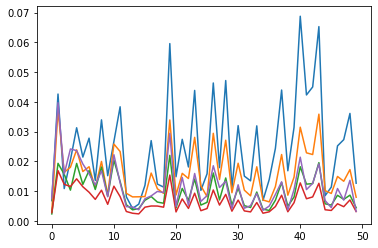

In [16]:
from scipy.spatial import distance

dist_0, dist_2, dist_4, dist_6, dist_7  = [], [], [], [], []

for global_epoch in range(G_epoch-1):
    for layer_index in num_layers_list:
        globals()['dist_{}'.format(layer_index)].append(np.mean(distance.euclidean(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)], globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)])))



print("Distance Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------")
print(dist_0)
print(dist_2)
print(dist_4)
print(dist_6)
print(dist_7, "\n\nCheck the graph\n")

plt.plot(dist_0)
plt.plot(dist_2)
plt.plot(dist_4)
plt.plot(dist_6)
plt.plot(dist_7)

plt.show()

In [17]:
#논문에 분산 얘기 할때 조심해야 할듯. 범위를 고려한다는 표현을 붙이던지 아님 거리의 평균 변화량이라고 표현하는 게 나을 듯

#중심점으로 수렴하는 것 = 거리 변화량 낮아짐

Average Acc and Loss Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------
[[0.8130252361297607, 0.7226890921592712, 0.7752100825309753, 0.8466386795043945, 0.8424369692802429, 0.8466386795043945, 0.7668067216873169, 0.8340336084365845, 0.7668067216873169, 0.8277310729026794, 0.7016806602478027, 0.8508403301239014, 0.8571428656578064, 0.8067227005958557, 0.7668067216873169, 0.7331932783126831, 0.8340336084365845, 0.8004201650619507, 0.848739504814148, 0.8361344337463379], [0.09453781694173813, 0.08613445609807968, 0.6092436909675598, 0.581932783126831, 0.1071428582072258, 0.10504201799631119, 0.11344537883996964, 0.5567227005958557, 0.6407563090324402, 0.08403361588716507, 0.10084033757448196, 0.10504201799631119, 0.11344537883996964, 0.0882352963089943, 0.1071428582072258, 0.0903361365199089, 0.6407563090324402, 0.10924369841814041, 0.10504201799631119, 0.06932773441076279], [0.668067216873169, 0.6869747638702393, 0.71848738

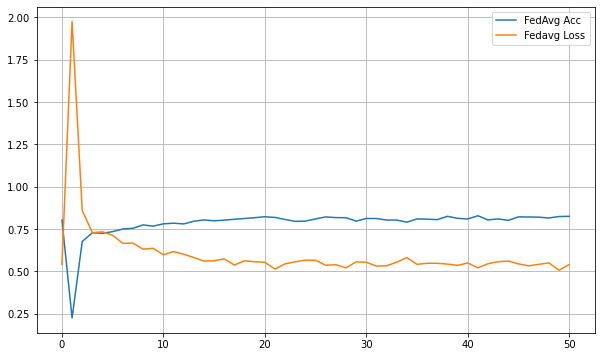

In [18]:
average_acc_list, average_loss_list = [], []


for i in range(len(FedAvg_ACC)):
    average_acc_list.append(np.mean(FedAvg_ACC[i]))
    average_loss_list.append(np.mean(FedAvg_LOSS[i]))
    

print("Average Acc and Loss Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------")
print(FedAvg_ACC)
print(FedAvg_LOSS)
print("\n\n Now Check the graph\n")

plt.figure(figsize=(10,6))
plt.plot(average_acc_list, label='FedAvg Acc')

plt.plot(average_loss_list, label='Fedavg Loss')

plt.grid(True)
plt.legend()
plt.show()
